## Stream Clustering

### 0. Installing Kafka
Follow the steps in this video : https://www.youtube.com/watch?v=LX5LKBYHmyU
(Note : Kafka requires that you have Java installed)

### 1. Start zookeeper and kafka servers
Navigate to kafka installation's directory and run the following two commands (on separate terminals):

#### Linux:
```bash
bin/zookeeper-server-start.sh config/zookeeper.properties
bin/kafka-server-start.sh config/server.properties
```

#### Windows:
```bash
.\bin\windows\zookeeper-server-start.bat .\config\zookeeper.properties
.\bin\windows\kafka-server-start.bat .\config\server.properties
```

### 2. Create a kafka topic that producers can publish to
Navigate to kafka installation's directory and run the following command:

**Note :** If a kafka stream with the name `mock_stream` already exists skip this step

#### Linux:
```bash
bin/kafka-topics.sh --create --bootstrap-server localhost:9092 --replication-factor 1 --partitions 1 --topic mock_stream 
```

#### Windows:
```bash
.\bin\windows\kafka-topics.bat --create --bootstrap-server localhost:9092 --replication-factor 1 --partitions 1 --topic mock_stream
```

### 3. Create producer script `data_stream.py`
```python
import time
import random
import numpy as np
import pandas as pd
import json
from kafka import KafkaProducer
from faker import Faker
    
def clamp(val, min_val, max_val):
    return min(max(min_val, val), max_val)

def generate_data(fake, mock_df):
    global ind

    data = {
        'instance_id': fake.uuid4(),
        'cpu_usage_percent': clamp(mock_df.iloc[ind]['CPU Utilization'] + random.uniform(-5, 5), 0, 100),
        'memory_usage_percent': clamp(mock_df.iloc[ind]['Memory Usage'] + random.uniform(-5, 5), 0, 100),
        'disk_usage_percent': clamp(mock_df.iloc[ind]['Disk IO'] + random.uniform(-5, 5), 0, 100),
        'network_latency' : clamp(mock_df.iloc[ind]['Network Latency'] + random.uniform(-3, 3), 0, 80)
    }
    
    ind = (ind + 1) % len(mock_df)

    return data



DATA_PATH = "./mock_data.csv"
mock_df = pd.read_csv(DATA_PATH)
mock_df = mock_df.drop("Load", axis = 1)
ind = 0

fake = Faker()
producer = KafkaProducer(bootstrap_servers='localhost:9092')
topic = 'mock_stream'

while True:

    data = generate_data(fake, mock_df)
    producer.send(topic, value=json.dumps(data).encode('utf-8'))
    time.sleep(random.random() * 0.1)
```

### 4. Run the producer script `data_stream.py`
```bash
python data_stream.py
```

### 5. Run the cells below to consume from the topic and perform clustering on the stream data periodically

In [6]:
!pip install kafka faker

In [1]:
%matplotlib inline

In [1]:
import time
from faker import Faker
from kafka import KafkaConsumer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd

import json
import random
import numpy as np
import matplotlib.pyplot as plt

In [72]:
INTERVAL_SAMPLE_SIZE = 250    # how many datapoints are to be collected before performing clustering
POLL_INTERVAL = 1             # polling frequency in seconds
N_INTERVALS_COMPARED = 2      # numbers of intervals to retain for clustering comparisons
N_CLUSTERS = 3                # number of clusters generated after clustering
MAX_INTERVALS = 5             # Maximum number of intervals

FEATURES = pd.Index(['CPU Utilization', 'Memory Usage', 'Disk IO', 'Network Latency'])
AXIS_LABELS = {'x' : 'CPU usage percent', 'y' : 'Disk usage percent'}

In [73]:
def generate_rgb():
    return random.sample(list(np.array(range(0, 256))/256), 3)


class StreamInterval:
    '''
    Process and visualize an interval of data from the data stream
    '''
    
    def __init__(self, interval_samples, features, interval_ind):
        self.data = interval_samples
        self.features = features
        self.interval_ind = interval_ind
        
    def cluster(self, n_clusters = 8, kmeans_init = 'k-means++'):
        self.n_clusters = n_clusters
        
        if kmeans_init is None:
            kmeans_init = 'k-means++'
        elif type(kmeans_init) != str:
            assert kmeans_init.shape[0] == n_clusters
            
        
        self.model = KMeans(n_clusters = self.n_clusters, init = kmeans_init)
        self.model.fit(self.data)
        self.labels = self.model.labels_
        
        return self.model.cluster_centers_
        
    def plot(self, ax, cluster_colors, title = "", plot_indices = [0, 1], plot_axis_labels = {'x' : 'X', 'y' : 'Y'}):
        
        data = self.data

        # Apply PCA to identify the two features that contribute the most amount of variance to the data sample
        pca = PCA(n_components = 1)
        pca.fit(data)
        
        component = pca.components_[0]
        plot_indices = abs(component).argsort()[-2:]
        plot_axis_labels = dict(zip(['x', 'y'], self.features[plot_indices]))
        
        
        for cluster_ind in range(self.n_clusters):
            x = data[self.labels == cluster_ind, plot_indices[0]]
            y = data[self.labels == cluster_ind, plot_indices[1]]
            
            ax.scatter(x, y, c = [cluster_colors[cluster_ind]])
            
        ax.set(xlabel = plot_axis_labels['x'], ylabel = plot_axis_labels['y'])
        ax.set_title(title)
        
        

INTERVAL 2


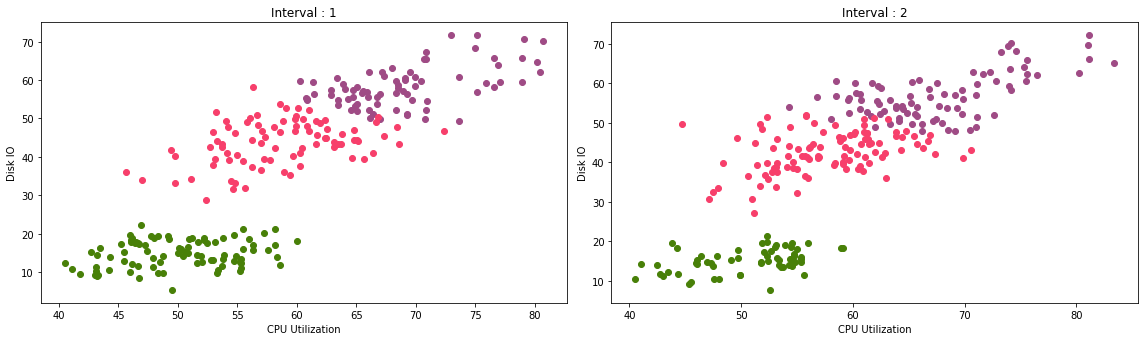

INTERVAL 3


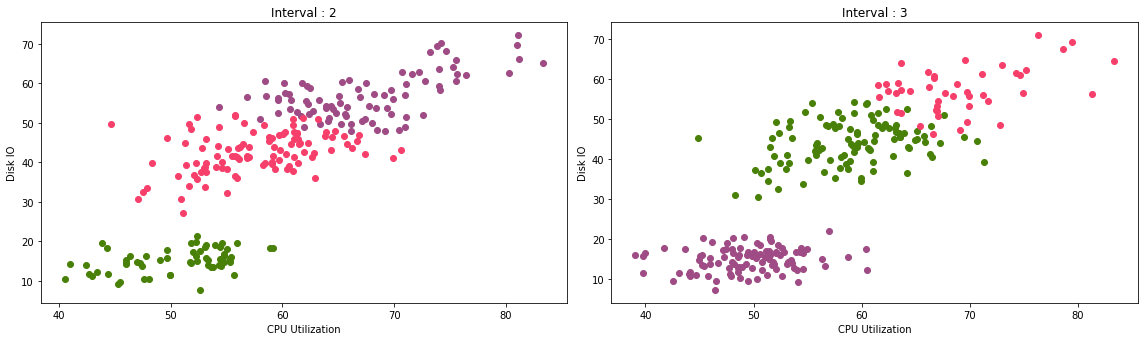

INTERVAL 4


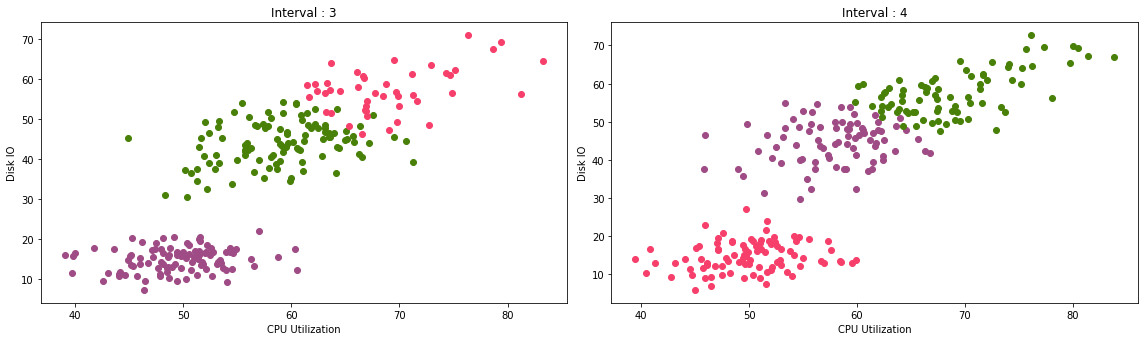

INTERVAL 5


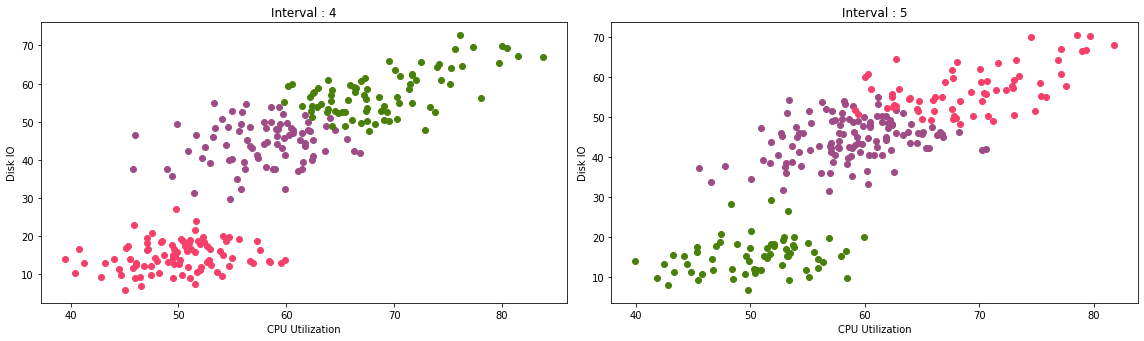

In [76]:
queue = []
intervals = 0
cluster_colors = [generate_rgb() for _ in range(N_CLUSTERS)]


consumer = KafkaConsumer('mock_stream', bootstrap_servers='localhost:9092', value_deserializer=lambda x: json.loads(x.decode('utf-8')))

while(intervals < MAX_INTERVALS):
    interval_samples = []
    for message in consumer:
        message.value.pop('instance_id', None)
        interval_samples.append(list(message.value.values()))

        if len(interval_samples) >= INTERVAL_SAMPLE_SIZE:
            break
            
    intervals += 1    
    data = np.array(interval_samples).astype(np.float64)
    stream_interval = StreamInterval(data, FEATURES, intervals)
    stream_interval.cluster(n_clusters = N_CLUSTERS)
    queue.append(stream_interval)
    
    if len(queue) < N_INTERVALS_COMPARED:
        continue
    elif len(queue) > N_INTERVALS_COMPARED:
        queue.pop(0)
        
        
    print(f'INTERVAL {intervals}')
    fig, axs = plt.subplots(1, len(queue), squeeze=False, figsize = (16, 5))
    
    for interval_ind, stream_interval in enumerate(queue):
        stream_interval.plot(axs[0, interval_ind],
                             cluster_colors,
                             title = f'Interval : {stream_interval.interval_ind}',
                             plot_axis_labels = AXIS_LABELS)
    
    fig.suptitle('')
    fig.tight_layout()
    plt.show()
    
    time.sleep(POLL_INTERVAL)
            

INTERVAL 2


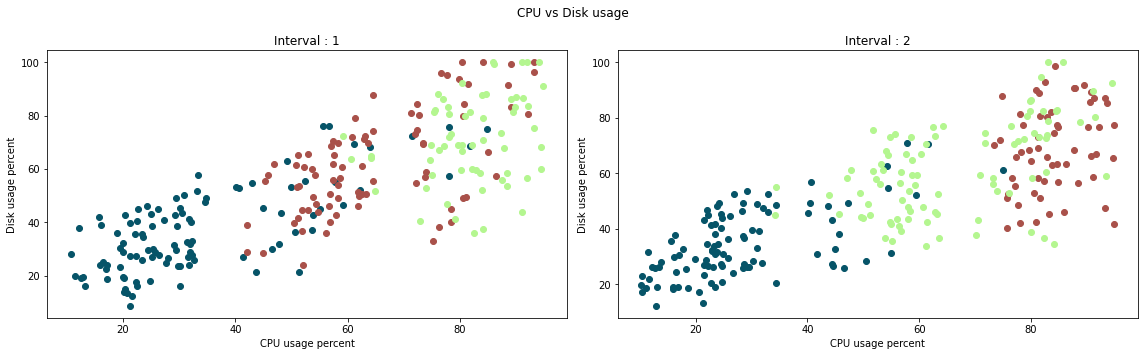

INTERVAL 3


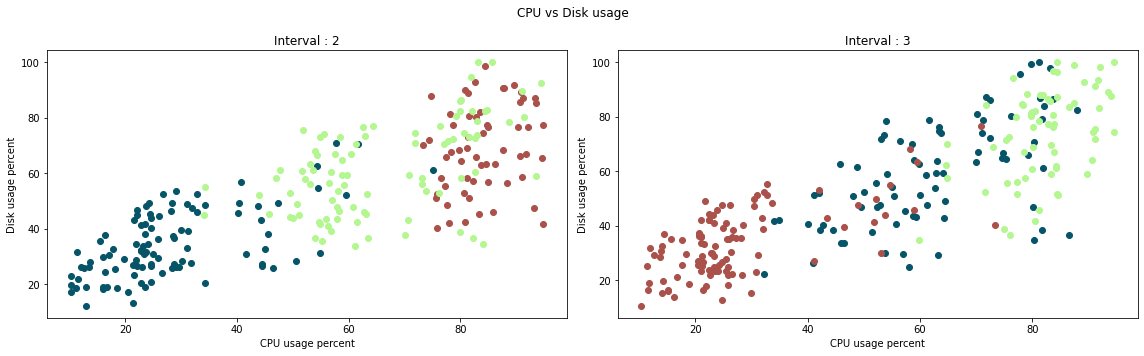

INTERVAL 4


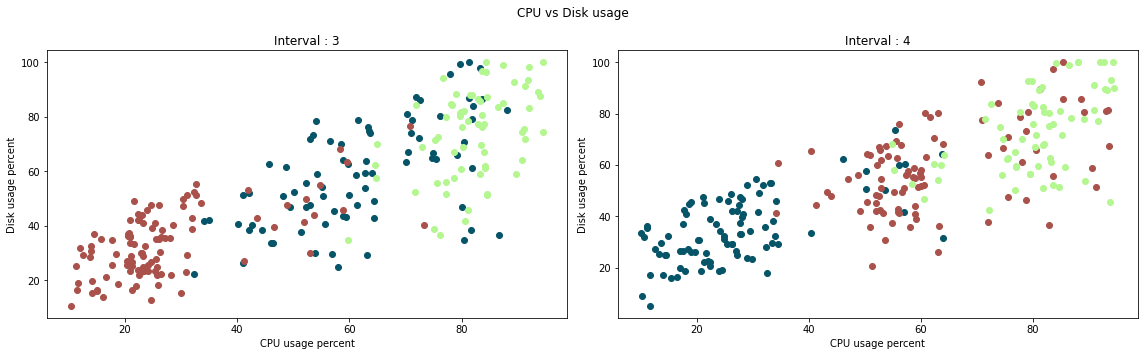

INTERVAL 5


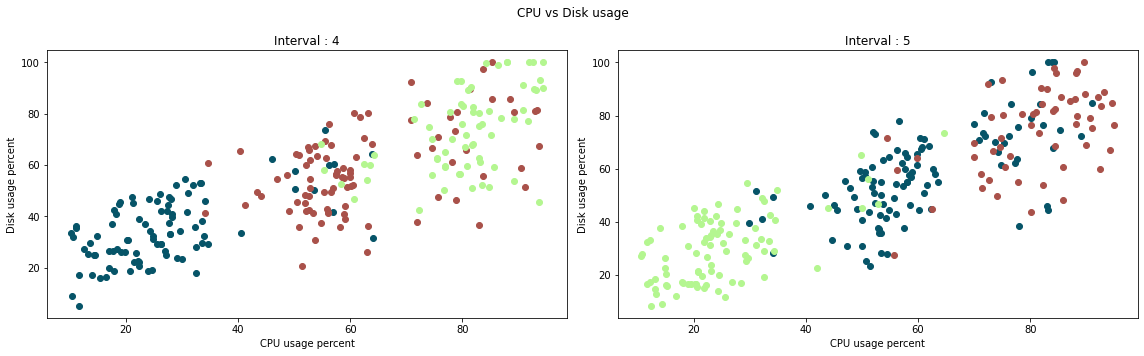

In [51]:
queue = []
intervals = 0
cluster_colors = [generate_rgb() for _ in range(N_CLUSTERS)]


consumer = KafkaConsumer('mock_stream', bootstrap_servers='localhost:9092', value_deserializer=lambda x: json.loads(x.decode('utf-8')))

while(intervals < MAX_INTERVALS):
    interval_samples = []
    for message in consumer:
        message.value.pop('instance_id', None)
        interval_samples.append(list(message.value.values()))

        if len(interval_samples) >= INTERVAL_SAMPLE_SIZE:
            break
            
    intervals += 1    
    data = np.array(interval_samples).astype(np.float64)
    stream_interval = StreamInterval(data, FEATURES, intervals)
    stream_interval.cluster(n_clusters = N_CLUSTERS)
    queue.append(stream_interval)
    
    if len(queue) < N_INTERVALS_COMPARED:
        continue
    elif len(queue) > N_INTERVALS_COMPARED:
        queue.pop(0)
        
        
    print(f'INTERVAL {intervals}')
    fig, axs = plt.subplots(1, len(queue), squeeze=False, figsize = (16, 5))
    
    for interval_ind, stream_interval in enumerate(queue):
        stream_interval.plot(axs[0, interval_ind],
                             cluster_colors,
                             title = f'Interval : {stream_interval.interval_ind}',
                             plot_axis_labels = AXIS_LABELS)
    
    fig.suptitle('CPU vs Disk usage')
    fig.tight_layout()
    plt.legend()
    plt.show()
    
    time.sleep(POLL_INTERVAL)
            